In [1]:
import os, sys, zipfile, subprocess, shutil
try:
    subprocess.run(["kaggle","datasets","download","-d","zalandoresearch/fashionmnist","-p","/kaggle/input/fashionmnist","--unzip"], check=True)
    DATA_DIR="/kaggle/input/fashionmnist"
except Exception:
    DATA_DIR="./fashion_mnist_data"
    os.makedirs(DATA_DIR, exist_ok=True)

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pathlib import Path
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_DIR = Path("autoencoder_outputs")
OUT_DIR.mkdir(exist_ok=True)

In [3]:
from PIL import Image
if os.path.exists(DATA_DIR) and any(Path(DATA_DIR).glob("*")):
    # try to detect common structure: if idx files (mnist style) -> use torchvision's dataset loader
    try:
        train_dataset = datasets.FashionMNIST(root=DATA_DIR, train=True, download=False, transform=transforms.ToTensor())
        test_dataset  = datasets.FashionMNIST(root=DATA_DIR, train=False, download=False, transform=transforms.ToTensor())
    except Exception:
        transform = transforms.Compose([transforms.Grayscale(), transforms.Resize((28,28)), transforms.ToTensor()])
        # assume images in folders; fall back to ImageFolder if present
        from torchvision.datasets import ImageFolder
        train_dataset = ImageFolder(root=DATA_DIR, transform=transform)
        test_dataset = train_dataset
else:
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root="./", train=True, download=True, transform=transform)
    test_dataset  = datasets.FashionMNIST(root="./", train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 26.4M/26.4M [00:00<00:00, 28.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.55MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 46.2MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.04MB/s]


In [4]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), # 28->14
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 14->7
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 7->7
            nn.ReLU(inplace=True),
        )
        self.enc_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*128, latent_dim)
        )
        self.dec_fc = nn.Sequential(
            nn.Linear(latent_dim, 7*7*128),
            nn.Unflatten(1, (128,7,7))
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1), # 7->7
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), #7->14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), #14->28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        z = self.enc_fc(h)
        return z

    def decode(self, z):
        h = self.dec_fc(z)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon

latent_dim = 64
model = ConvAutoencoder(latent_dim=latent_dim).to(device)


In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
num_epochs = 40
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
train_losses = []
val_losses = []
best_val = 1e9
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, *_ in train_loader:
        if isinstance(imgs, (list,tuple)): imgs = imgs[0]
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for imgs, *_ in test_loader:
            if isinstance(imgs, (list,tuple)): imgs = imgs[0]
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            running_val += loss.item() * imgs.size(0)
    epoch_val_loss = running_val / len(test_loader.dataset)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)
    if epoch_val_loss < best_val:
        best_val = epoch_val_loss
        torch.save(model.state_dict(), OUT_DIR/"best_autoencoder.pth")
    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")
torch.save(model.state_dict(), OUT_DIR/"final_autoencoder.pth")
with open(OUT_DIR/"losses.json","w") as f:
    json.dump({"train":train_losses,"val":val_losses}, f)


Epoch 1/40 | Train Loss: 0.024282 | Val Loss: 0.013115
Epoch 2/40 | Train Loss: 0.011005 | Val Loss: 0.009555
Epoch 3/40 | Train Loss: 0.008757 | Val Loss: 0.008029
Epoch 4/40 | Train Loss: 0.007623 | Val Loss: 0.007175
Epoch 5/40 | Train Loss: 0.006961 | Val Loss: 0.006761
Epoch 6/40 | Train Loss: 0.006549 | Val Loss: 0.006548
Epoch 7/40 | Train Loss: 0.006290 | Val Loss: 0.006354
Epoch 8/40 | Train Loss: 0.006142 | Val Loss: 0.006231
Epoch 9/40 | Train Loss: 0.006016 | Val Loss: 0.006124
Epoch 10/40 | Train Loss: 0.005922 | Val Loss: 0.005940
Epoch 11/40 | Train Loss: 0.005840 | Val Loss: 0.005827
Epoch 12/40 | Train Loss: 0.005774 | Val Loss: 0.005771
Epoch 13/40 | Train Loss: 0.005718 | Val Loss: 0.005770
Epoch 14/40 | Train Loss: 0.005659 | Val Loss: 0.005738
Epoch 15/40 | Train Loss: 0.005612 | Val Loss: 0.005620
Epoch 16/40 | Train Loss: 0.005572 | Val Loss: 0.005655
Epoch 17/40 | Train Loss: 0.005541 | Val Loss: 0.005643
Epoch 18/40 | Train Loss: 0.005495 | Val Loss: 0.005524
E

In [7]:
import torchvision
def save_reconstructions(model, dataloader, n=8, fname=OUT_DIR/"reconstructions.png"):
    model.eval()
    imgs, _ = next(iter(dataloader))
    if isinstance(imgs, (list,tuple)): imgs = imgs[0]
    imgs = imgs[:n].to(device)
    with torch.no_grad():
        recons = model(imgs)
    grid = torchvision.utils.make_grid(torch.cat([imgs, recons], dim=0).cpu(), nrow=n)
    torchvision.utils.save_image(grid, str(fname))
save_reconstructions(model, test_loader, n=8)


In [8]:
def extract_latents(model, dataloader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for imgs, labs in dataloader:
            if isinstance(imgs, (list,tuple)): imgs = imgs[0]
            imgs = imgs.to(device)
            z = model.encode(imgs)
            latents.append(z.cpu().numpy())
            labels.append(labs.numpy())
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    return latents, labels

latents, labels = extract_latents(model, test_loader)
np.save(OUT_DIR/"latents.npy", latents)
np.save(OUT_DIR/"labels.npy", labels)


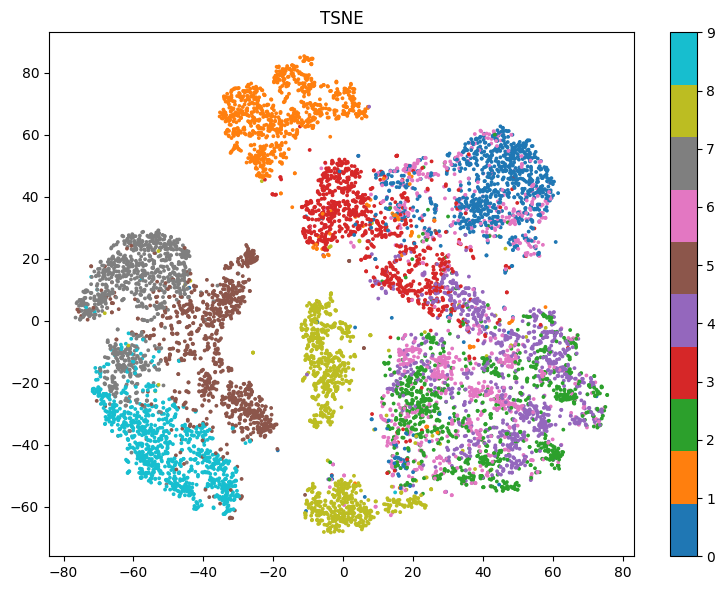

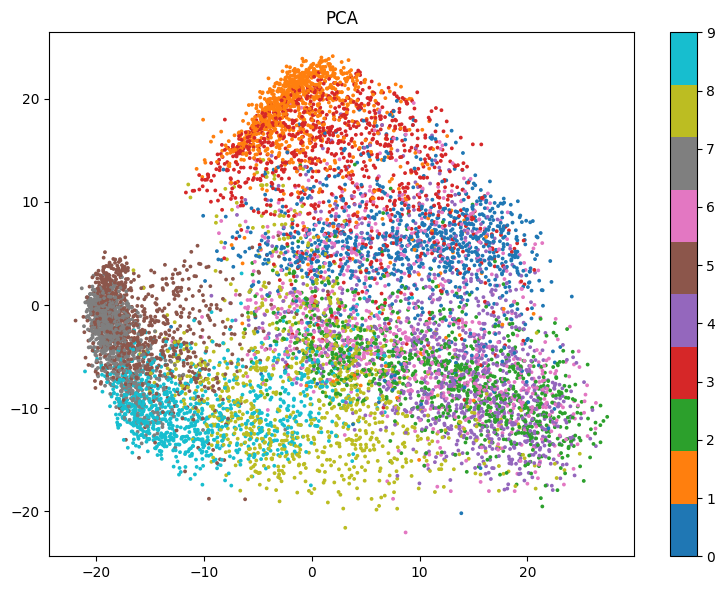

In [9]:
def plot_tsne(latents, labels, method="tsne", out=OUT_DIR/"tsne.png"):
    if method=="pca":
        emb = PCA(n_components=2).fit_transform(latents)
    else:
        emb = TSNE(n_components=2, perplexity=30, init='pca', random_state=42).fit_transform(latents)
    plt.figure(figsize=(8,6))
    sc = plt.scatter(emb[:,0], emb[:,1], c=labels, s=3, cmap="tab10")
    plt.colorbar(sc, ticks=range(10))
    plt.title(method.upper())
    plt.tight_layout()
    plt.savefig(out, dpi=150)
plot_tsne(latents, labels, method="tsne", out=OUT_DIR/"tsne.png")
plot_tsne(latents, labels, method="pca", out=OUT_DIR/"pca.png")


In [10]:
def latent_interpolation(model, dataloader, steps=8, out=OUT_DIR/"interpolation.png"):
    model.eval()
    imgs, _ = next(iter(dataloader))
    if isinstance(imgs, (list,tuple)): imgs = imgs[0]
    a = imgs[0:1].to(device)
    b = imgs[1:2].to(device)
    with torch.no_grad():
        za = model.encode(a)
        zb = model.encode(b)
        inters = []
        for alpha in np.linspace(0,1,steps):
            z = za*(1-alpha)+zb*(alpha)
            x = model.decode(z)
            inters.append(x.cpu())
    grid = torchvision.utils.make_grid(torch.cat(inters, dim=0), nrow=steps)
    torchvision.utils.save_image(grid, str(out))
latent_interpolation(model, test_loader, steps=10)


In [11]:
import pandas as pd
model.eval()
per_class = {}
counts = {}
with torch.no_grad():
    for imgs, labs in test_loader:
        if isinstance(imgs, (list,tuple)): imgs = imgs[0]
        imgs = imgs.to(device)
        labs = labs.numpy()
        outs = model(imgs)
        mse = torch.mean((outs - imgs)**2, dim=[1,2,3]).cpu().numpy()
        for m,l in zip(mse,labs):
            per_class.setdefault(l,0.0)
            counts.setdefault(l,0)
            per_class[l] += float(m)
            counts[l] += 1
rows=[]
total=0.0
totcount=0
for k in sorted(per_class.keys()):
    avg = per_class[k]/counts[k]
    rows.append({"class":int(k),"mse":avg,"count":counts[k]})
    total += per_class[k]
    totcount += counts[k]
df = pd.DataFrame(rows)
df.to_csv(OUT_DIR/"mse_per_class.csv", index=False)
overall_mse = total/totcount
with open(OUT_DIR/"metrics.json","w") as f:
    json.dump({"overall_mse":overall_mse}, f)
print("overall_mse", overall_mse)


overall_mse 0.00531912903872435


In [12]:
from PIL import ImageOps
def load_model(path):
    m = ConvAutoencoder(latent_dim=latent_dim).to(device)
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()
    return m

m = load_model(OUT_DIR/"best_autoencoder.pth")
save_reconstructions(m, test_loader, n=8, fname=OUT_DIR/"best_reconstructions.png")


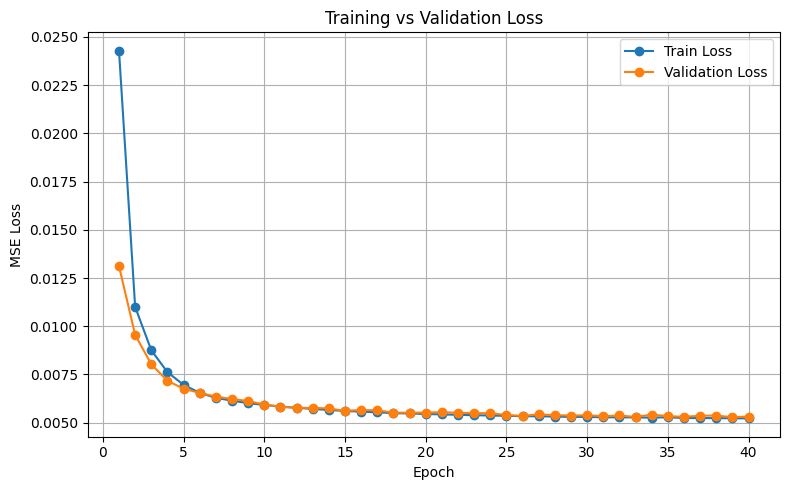

In [13]:
import json
import matplotlib.pyplot as plt

# Load loss dari file JSON (hasil training sebelumnya)
with open(OUT_DIR/"losses.json","r") as f:
    losses = json.load(f)

train_losses = losses["train"]
val_losses = losses["val"]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR/"loss_curve.png", dpi=150)  # Simpan gambar loss
plt.show()
